In [1]:
import os
import cv2
import math
import keras
import seaborn
import time
import warnings
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.models import Model
from keras import layers, models
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
np.random.seed(0)
K.set_image_data_format('channels_last')

create_image_rows = 420
create_image_cols = 580
smooth = 1.0

In [4]:
mask_t = np.load('./imgs_mask_train.npy')
image_t = np.load('./imgs_train.npy')

warnings.filterwarnings(action='ignore')

In [5]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [6]:
def SRAD(i, niter, lamda, rect):
    # make image a double and normalize on[0, 1]
    i = i.astype('float32')
    mx = np.max(i[:])
    mn = np.min(i[:])
    i = (i-mn)/(mx-mn)

    # make image a double and normalize on[0, 1]
    [M, N] = np.shape(i)

    # image indices (using boudary conditions)
    iN = np.hstack((np.array(0),np.arange(0,M-1)))
    iS = np.hstack((np.arange(1,M-1),np.array(M-1),np.array(M-1)))
    jW = np.hstack((np.array(0),np.arange(0,N-1)))
    jE = np.hstack((np.arange(1,N-1),np.array(N-1),np.array(N-1)))
    
    # log uncompress (also eliminates zero value pixels)
    i = np.exp(i)

    # main algorithm
    for liter in np.arange(1,niter+1):

         # speckle scale function
        Iuniform = i[rect[0]:rect[1],rect[2]:rect[3]]
        q0_squared = np.var(Iuniform[:]) / ((np.mean(Iuniform[:]))**2)

        # difference
        dN = i[iN, :] - i
        dS = i[iS, :] - i
        dW = i[:, jW] - i
        dE = i[:, jE] - i

        # normalized discrete gradient magnitude squared (equ 52,53)
        G2 = (pow(dN,2) + pow(dS, 2) + pow(dW, 2) + pow(dE, 2)) / (pow(i, 2))

        # normalized discrete laplacian (equ 54)
        L = (dN + dS + dW + dE)/i

        # ICOV (equ 31/35)
        num = (0.5*G2) - ((1/16)*(pow(L, 2)))
        den = pow((1 + ((1/4)*L)), 2)
        q_squared = num / (den + np.finfo(float).eps)

        # diffusion coefficent (equ 33)
        den = (q_squared - q0_squared) / (q0_squared * (1 + q0_squared) +np.finfo(float).eps)
        c = 1 / (1 + den)

        # saturate diffusion coefficent
        c[c < 0] = 0
        c[c > 1] = 1

        # divergence (equ 58)
        cS = c[iS, :]
        cE = c[:,jE]
        D = (c*dN) + (cS*dS) + (c*dW) + (cE*dE)
        
        # update
        i = i + (lamda/4)*D; 
        
    J = np.log(i)
    J=np.round(J*255)
    J=J.astype('uint8')
    return J

In [7]:
train_image_rows = 96
train_image_cols = 96
winodw_size = 9
import scipy 

def preprocess_msk(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        imgs_p[i] = resize(imgs[i].astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #img = lee_filter(imgs[i],11)
        #img = SRAD(imgs[i],5, 1, [0, 420, 0, 580])
        #img = scipy.signal.wiener(imgs[i].astype('float32'), mysize=5)
        #img = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        #img = imgs[i]
        imgs_p[i] = resize(img.astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std
        
    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [8]:
#image_c = preprocess_img(image_t)

In [9]:
mask_c = preprocess_msk(mask_t)

#mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection+ K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def recall(y_true, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred_f, 0, 1))
    # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_true_f, 0, 1))

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = (count_true_positive+ K.epsilon()) / \
        (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_true, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred_f, 0, 1))
    # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_true_f, 0, 1))

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = (count_true_positive+ K.epsilon()) / \
        (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def mean_iou(y_true, y_pred, smooth=1):
    y_pred_N = K.round(K.clip(y_pred, 0, 1))
    y_true_N = K.round(K.clip(y_true, 0, 1))
    intersection = K.sum(K.abs(y_pred_N * y_true_N), axis=-1)
    union = K.sum(y_true_N, axis=-1) + K.sum(y_pred_N, axis=-1)
    iou = (intersection+ K.epsilon()) / (union+ K.epsilon())
    return iou

In [11]:
from keras import regularizers

def auto_encoder():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))
    conv1 = layers.Conv2D(32, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.001), padding='same', kernel_initializer='lecun_normal')(inputs)
    conv1 = layers.Dropout(0.1)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.001), padding='same', kernel_initializer='lecun_normal')(pool1)
    conv2 = layers.Dropout(0.1)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.001), padding='same', kernel_initializer='lecun_normal')(pool2)
    conv3 = layers.Dropout(0.1)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.001), padding='same', kernel_initializer='lecun_normal')(pool3)
    conv4 = layers.Dropout(0.1)(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.001), padding='same', kernel_initializer='lecun_normal')(pool4)
    conv5 = layers.Dropout(0.1)(conv5)

    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5)
    up6 = layers.Dropout(0.1)(up6)

    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(up6)
    up7 = layers.Dropout(0.1)(up7)

    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(up7)
    up8 = layers.Dropout(0.1)(up8)

    up9 = layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(up8)
    up9 = layers.Dropout(0.1)(up9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=keras.optimizers.Adam(lr=.0002), loss=dice_coef_loss, metrics=[
                  dice_coef, recall, precision, mean_iou])


    return model

In [12]:
CAE = auto_encoder()

W1103 22:07:15.301915 50948 deprecation_wrapper.py:119] From d:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [13]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(
        name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    early_stopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    tb_hist = TensorBoard(log_dir='./logs',
                          histogram_freq=0, write_grads=True, write_images=True)
    return [mcp_save, reduce_lr_loss, early_stopping, tb_hist]

In [ ]:
import h5py

image_t =h5py.File('./imgs_train_DPAD_3_2.h5', 'r')
image_t =image_t.get('image')
image_t= np.array(image_t)
image_t=np.transpose(image_t)

In [14]:
winodw_size = 9
def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #img = lee_filter(imgs[i],3)
        #img = SRAD(imgs[i],30, 1, [0, 420, 0, 580])
        #img = scipy.signal.wiener(imgs[i].astype('float32'), mysize=9)
        #img = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        img = imgs[i]
        imgs_p[i] = resize(img.astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std
        
    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

#image_c = preprocess_img(image_t)

In [14]:
def preprocess_img_n(imgs,lit):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #img = lee_filter(imgs[i],lit)
        #img = SRAD(imgs[i],lit, 1, [0, 420, 0, 580])
        #img = scipy.signal.wiener(imgs[i].astype('float32'), mysize=9)
        #img = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        img = imgs[i]
        imgs_p[i] = resize(img.astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std
        
    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [15]:
folds = list(StratifiedKFold(n_splits=5, shuffle=True,
                             random_state=42).split(image_c[:, 0, 0], mask_c[:, 0, 0]))

NameError: name 'image_c' is not defined



Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 7s - loss: 1.3759 - dice_coef: 0.2865 - recall: 0.5398 - precision: 0.2651 - mean_iou: 0.8418 - val_loss: 1.4410 - val_dice_coef: 0.1413 - val_recall: 0.9355 - val_precision: 0.0786 - val_mean_iou: 0.8582
Epoch 2/50
 - 6s - loss: 1.0587 - dice_coef: 0.4920 - recall: 0.5456 - precision: 0.4747 - mean_iou: 0.9837 - val_loss: 1.0581 - val_dice_coef: 0.4641 - val_recall: 0.5697 - val_precision: 0.4209 - val_mean_iou: 0.9824
Epoch 3/50
 - 5s - loss: 0.9485 - dice_coef: 0.5462 - recall: 0.5833 - precision: 0.5346 - mean_iou: 0.9852 - val_loss: 0.9977 - val_dice_coef: 0.4723 - val_recall: 0.4826 - val_precision: 0.5136 - val_mean_iou: 0.9860
Epoch 4/50
 - 6s - loss: 0.8784 - dice_coef: 0.5697 - recall: 0.6048 - precision: 0.5631 - mean_iou: 0.9857 - val_loss: 0.9757 - val_dice_coef: 0.4523 - val_recall: 0.7040 - val_precision: 0.3459 - val_mean_iou: 0.9767
Epoch 5/50
 - 5s - loss: 0.8181 - dice_coef: 0.5913 - recall: 0.61

Epoch 13/50
 - 6s - loss: 0.3163 - dice_coef: 0.7887 - recall: 0.7879 - precision: 0.8085 - mean_iou: 0.9904 - val_loss: 0.3170 - val_dice_coef: 0.7896 - val_recall: 0.7996 - val_precision: 0.8109 - val_mean_iou: 0.9910
Epoch 14/50
 - 6s - loss: 0.3149 - dice_coef: 0.7896 - recall: 0.7877 - precision: 0.8116 - mean_iou: 0.9904 - val_loss: 0.3177 - val_dice_coef: 0.7884 - val_recall: 0.8017 - val_precision: 0.8071 - val_mean_iou: 0.9910
Epoch 15/50
 - 6s - loss: 0.3160 - dice_coef: 0.7881 - recall: 0.7859 - precision: 0.8098 - mean_iou: 0.9904 - val_loss: 0.3182 - val_dice_coef: 0.7873 - val_recall: 0.8012 - val_precision: 0.8063 - val_mean_iou: 0.9910
Epoch 16/50
 - 6s - loss: 0.3137 - dice_coef: 0.7898 - recall: 0.7932 - precision: 0.8063 - mean_iou: 0.9904 - val_loss: 0.3276 - val_dice_coef: 0.7776 - val_recall: 0.7462 - val_precision: 0.8484 - val_mean_iou: 0.9913
Epoch 17/50
 - 6s - loss: 0.3096 - dice_coef: 0.7937 - recall: 0.7923 - precision: 0.8154 - mean_iou: 0.9905 - val_loss:

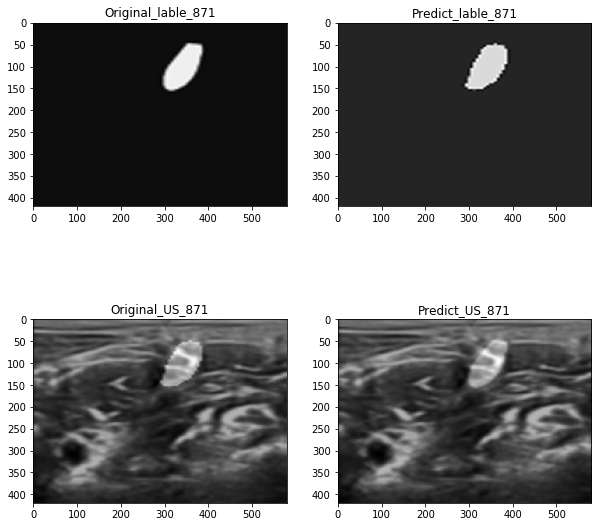

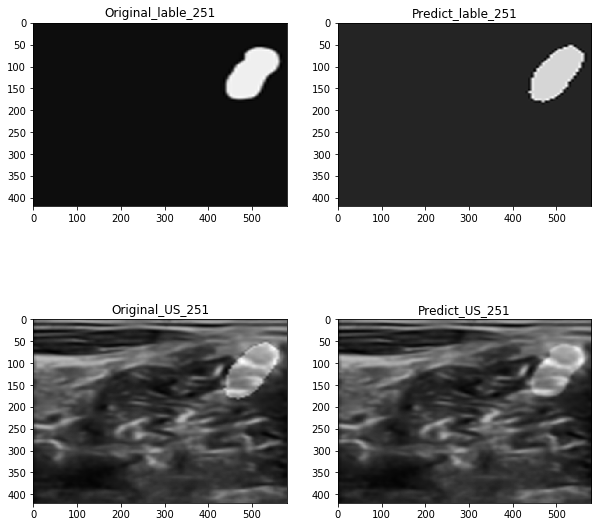

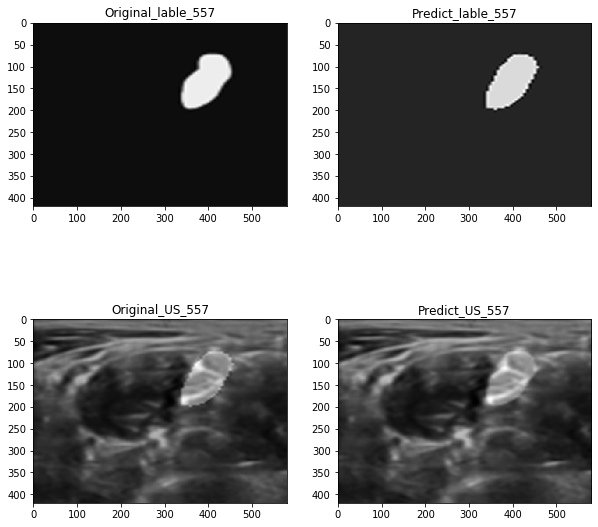

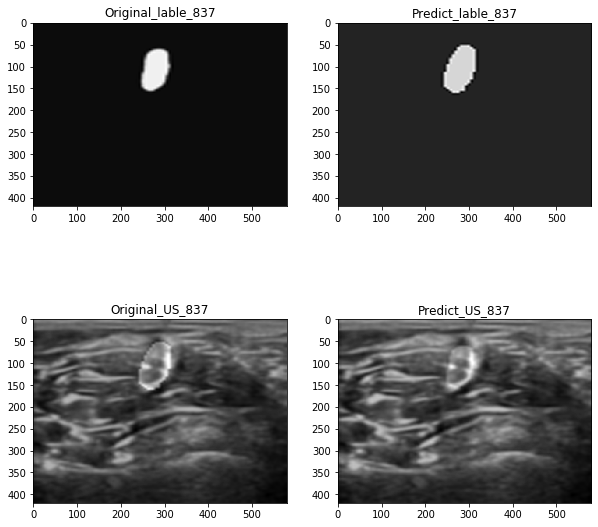

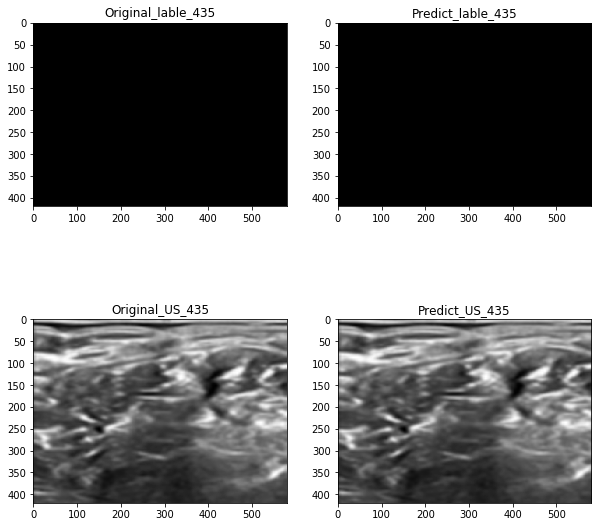

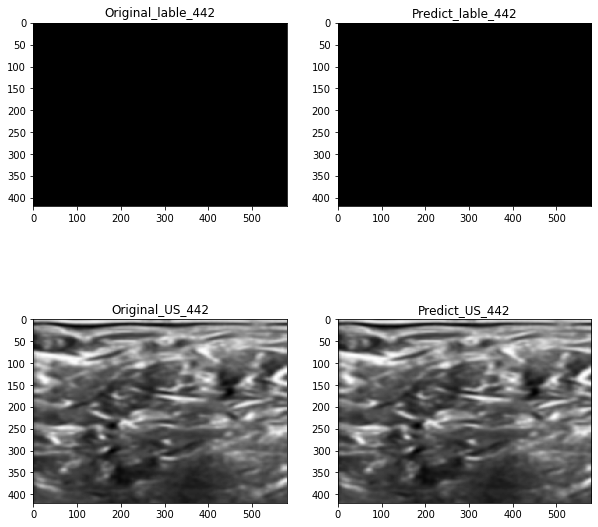

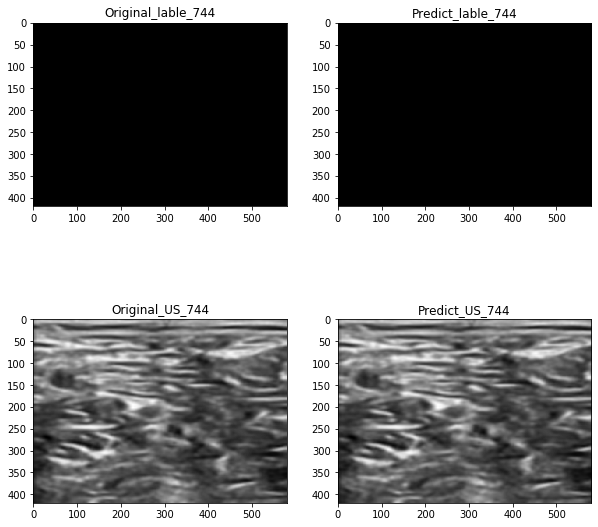

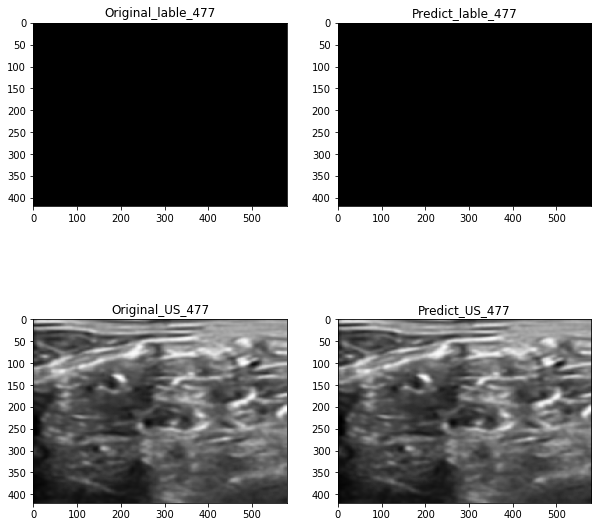

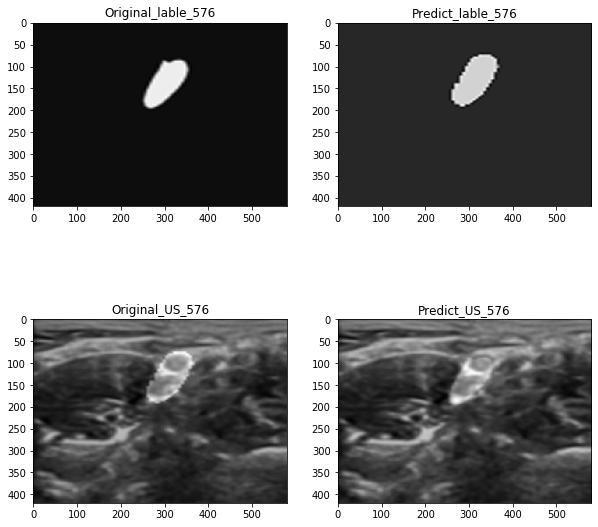

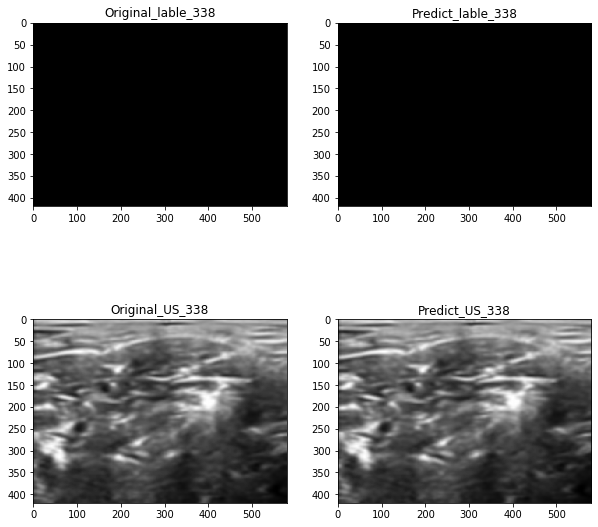


Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 7s - loss: 1.3980 - dice_coef: 0.2650 - recall: 0.5334 - precision: 0.2401 - mean_iou: 0.8479 - val_loss: 1.2339 - val_dice_coef: 0.3499 - val_recall: 0.6452 - val_precision: 0.2498 - val_mean_iou: 0.9692
Epoch 2/50
 - 6s - loss: 1.0660 - dice_coef: 0.4842 - recall: 0.5402 - precision: 0.4641 - mean_iou: 0.9833 - val_loss: 1.0812 - val_dice_coef: 0.4383 - val_recall: 0.6546 - val_precision: 0.3422 - val_mean_iou: 0.9777
Epoch 3/50
 - 6s - loss: 0.9565 - dice_coef: 0.5371 - recall: 0.5837 - precision: 0.5278 - mean_iou: 0.9849 - val_loss: 0.9782 - val_dice_coef: 0.4920 - val_recall: 0.5978 - val_precision: 0.4379 - val_mean_iou: 0.9831
Epoch 4/50
 - 6s - loss: 0.8811 - dice_coef: 0.5663 - recall: 0.6029 - precision: 0.5597 - mean_iou: 0.9857 - val_loss: 0.9345 - val_dice_coef: 0.4938 - val_recall: 0.6260 - val_precision: 0.4300 - val_mean_iou: 0.9824
Epoch 5/50
 - 6s - loss: 0.8134 - dice_coef: 0.5959 - recall: 0.621

Epoch 12/50
 - 6s - loss: 0.3233 - dice_coef: 0.7823 - recall: 0.7848 - precision: 0.7990 - mean_iou: 0.9902 - val_loss: 0.3121 - val_dice_coef: 0.7952 - val_recall: 0.8290 - val_precision: 0.7906 - val_mean_iou: 0.9908
Epoch 13/50
 - 6s - loss: 0.3202 - dice_coef: 0.7849 - recall: 0.7881 - precision: 0.8015 - mean_iou: 0.9903 - val_loss: 0.3127 - val_dice_coef: 0.7942 - val_recall: 0.8228 - val_precision: 0.7946 - val_mean_iou: 0.9908
Epoch 14/50
 - 6s - loss: 0.3174 - dice_coef: 0.7873 - recall: 0.7886 - precision: 0.8038 - mean_iou: 0.9903 - val_loss: 0.3128 - val_dice_coef: 0.7937 - val_recall: 0.8299 - val_precision: 0.7865 - val_mean_iou: 0.9907
Epoch 15/50
 - 6s - loss: 0.3128 - dice_coef: 0.7915 - recall: 0.7913 - precision: 0.8101 - mean_iou: 0.9904 - val_loss: 0.3134 - val_dice_coef: 0.7927 - val_recall: 0.8269 - val_precision: 0.7871 - val_mean_iou: 0.9907
Epoch 16/50
 - 6s - loss: 0.3123 - dice_coef: 0.7914 - recall: 0.7941 - precision: 0.8077 - mean_iou: 0.9904 - val_loss:

Epoch 12/50
 - 6s - loss: 0.3057 - dice_coef: 0.7958 - recall: 0.7964 - precision: 0.8129 - mean_iou: 0.9905 - val_loss: 0.2975 - val_dice_coef: 0.8053 - val_recall: 0.8327 - val_precision: 0.8076 - val_mean_iou: 0.9910
Epoch 13/50
 - 6s - loss: 0.3066 - dice_coef: 0.7948 - recall: 0.7959 - precision: 0.8128 - mean_iou: 0.9905 - val_loss: 0.2975 - val_dice_coef: 0.8054 - val_recall: 0.8325 - val_precision: 0.8078 - val_mean_iou: 0.9910

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.000000023372195e-08.
Epoch 00013: early stopping
[0.29749977493455376, 0.8053606748580933, 0.8324978351593018, 0.8078133463859558, 0.9910263419151306]


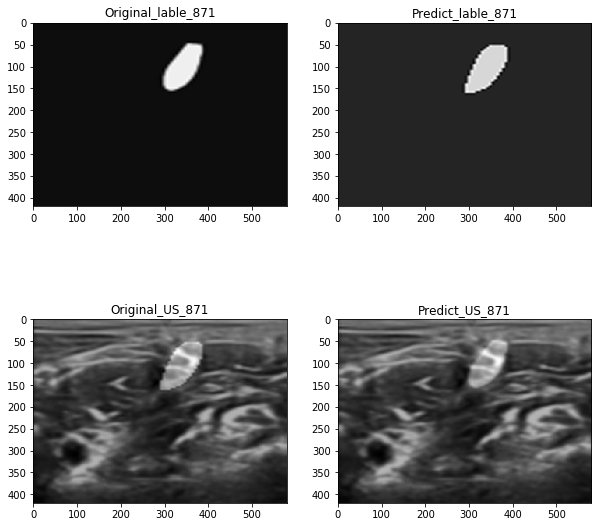

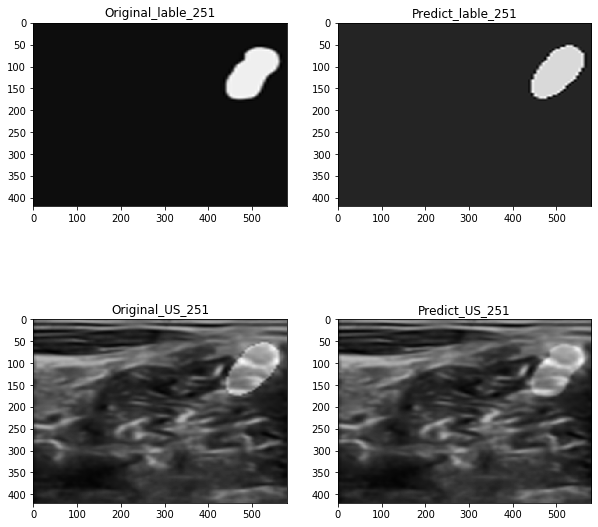

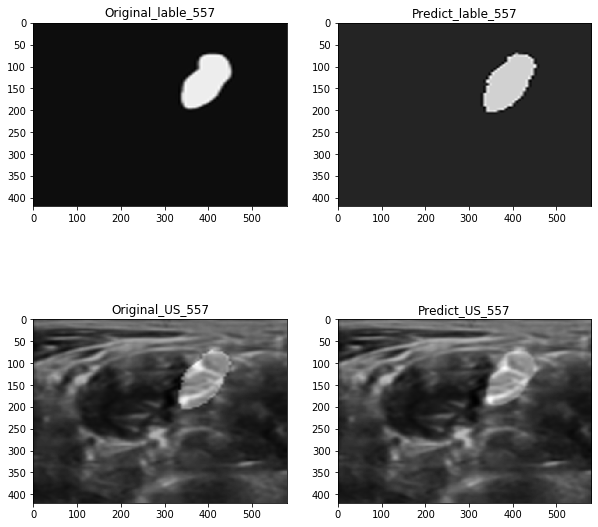

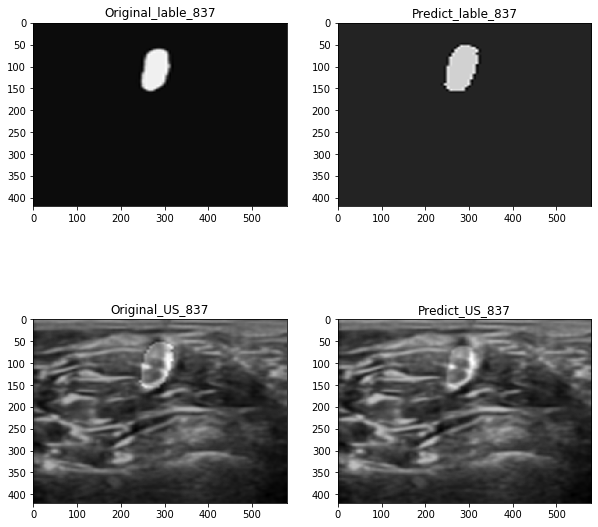

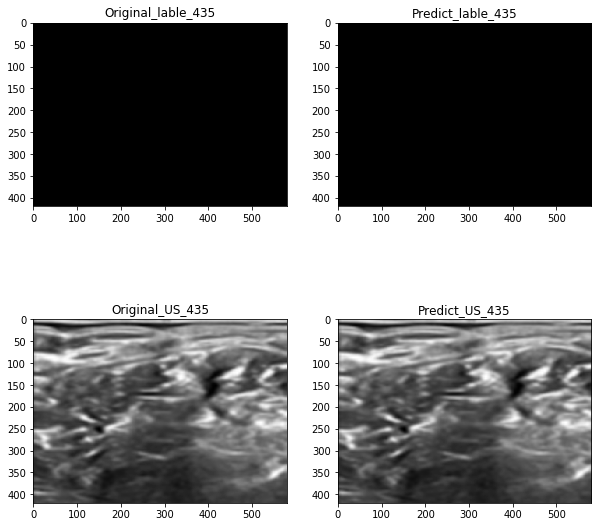

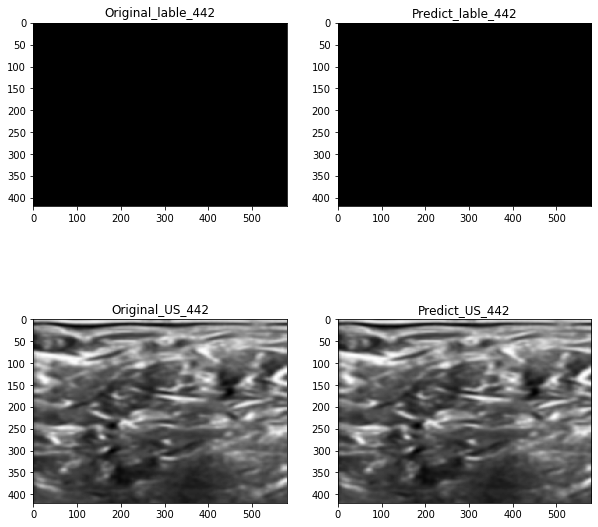

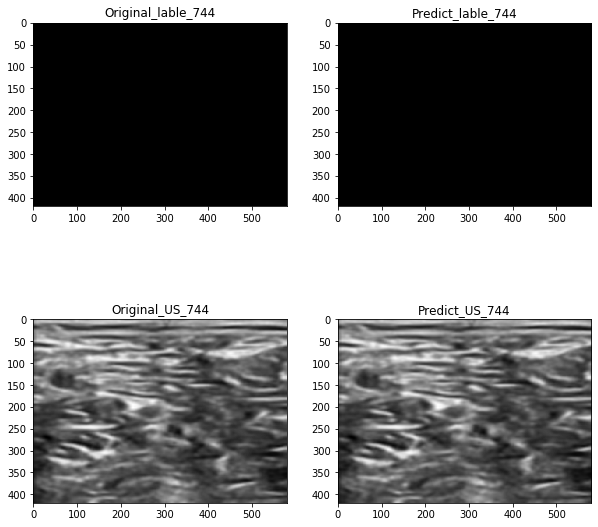

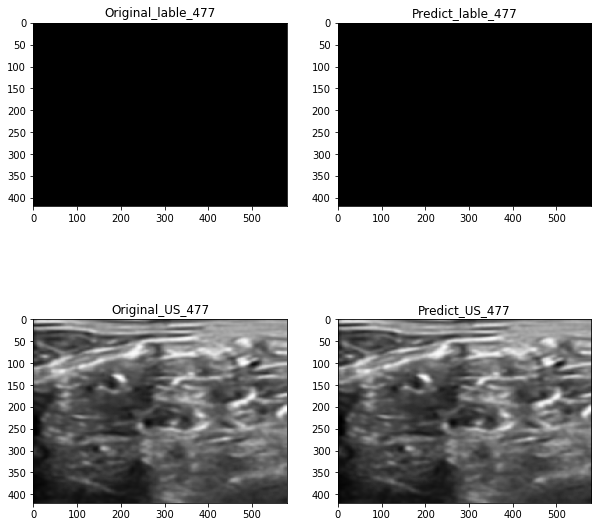

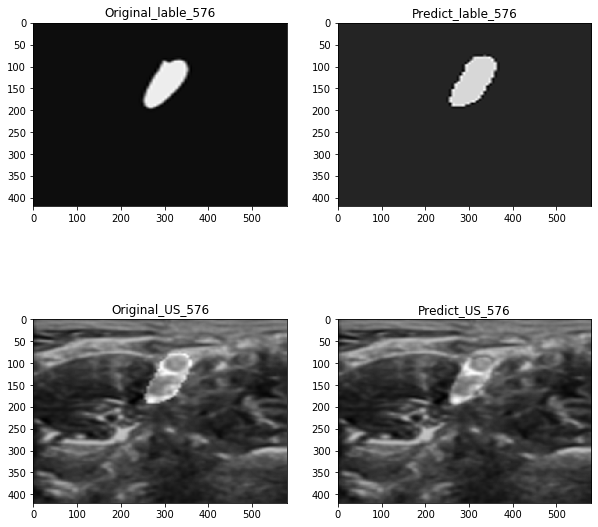

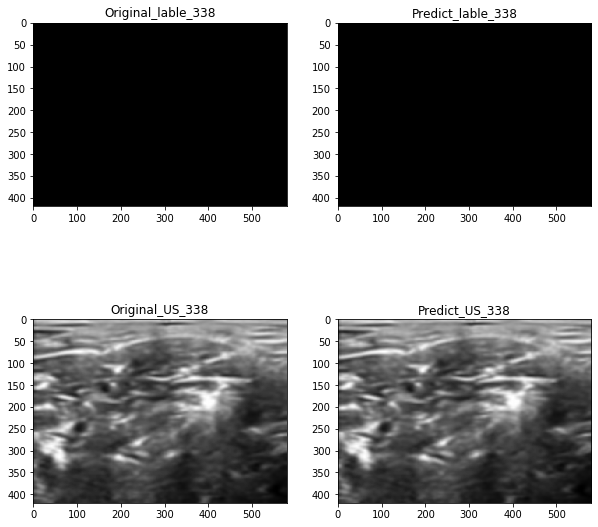


Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 7s - loss: 1.3939 - dice_coef: 0.2691 - recall: 0.5214 - precision: 0.2538 - mean_iou: 0.8490 - val_loss: 1.3699 - val_dice_coef: 0.2137 - val_recall: 0.8198 - val_precision: 0.1275 - val_mean_iou: 0.9246
Epoch 2/50
 - 6s - loss: 1.0724 - dice_coef: 0.4789 - recall: 0.5328 - precision: 0.4636 - mean_iou: 0.9833 - val_loss: 1.0748 - val_dice_coef: 0.4459 - val_recall: 0.5451 - val_precision: 0.3973 - val_mean_iou: 0.9823
Epoch 3/50
 - 6s - loss: 0.9602 - dice_coef: 0.5364 - recall: 0.5822 - precision: 0.5263 - mean_iou: 0.9849 - val_loss: 0.9893 - val_dice_coef: 0.4827 - val_recall: 0.4675 - val_precision: 0.5420 - val_mean_iou: 0.9868
Epoch 4/50
 - 6s - loss: 0.8845 - dice_coef: 0.5662 - recall: 0.6001 - precision: 0.5599 - mean_iou: 0.9858 - val_loss: 0.9298 - val_dice_coef: 0.5015 - val_recall: 0.6507 - val_precision: 0.4274 - val_mean_iou: 0.9821
Epoch 5/50
 - 6s - loss: 0.8185 - dice_coef: 0.5940 - recall: 0.627

In [ ]:
import h5py
for ind_fil in [7]:
    image_t =h5py.File('./imgs_train_Frost_'+str(ind_fil) +'.h5', 'r')
    image_t =image_t.get('image')
    image_t= np.array(image_t)
    image_t=np.transpose(image_t)
    image_c = preprocess_img(image_t)
    folds = list(StratifiedKFold(n_splits=5, shuffle=True,
                             random_state=42).split(image_c[:, 0, 0], mask_c[:, 0, 0]))
    for ind in ["/새 폴더 (5)","/새 폴더 (6)","/새 폴더 (7)","/새 폴더 (8)"]:
        path = "./Result/CAE/Frost/"+str(ind_fil) +ind
        winodw_size = 0
        CAE = auto_encoder()

        for j, (train_idx, val_idx) in enumerate(folds):
            now = time.localtime()
            s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                          now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
            print('\nFold ', j)
            image_train_cv = image_c[train_idx]
            mask_train_cv = mask_c[train_idx]
            image_valid_cv = image_c[val_idx]
            mask_valid_cv = mask_c[val_idx]

            name_weights = path+"/final_model_fold_" + \
                str(j) + str(winodw_size) + "_weights.h5"
            callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

            history = CAE.fit(image_train_cv, mask_train_cv, epochs=50, verbose=2, shuffle=True, validation_data=(
            image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

            if history.history['dice_coef'][-1] < 0.05:
                break
            df = pd.DataFrame({"val_loss": history.history['val_loss'],
                           "val_dice_coef": history.history['val_dice_coef'],
                           "val_precision": history.history['val_precision'],
                           "val_recall": history.history['val_recall']})
            df = df*100
            df.to_csv(
                path+'/history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
            print(CAE.evaluate(image_valid_cv, mask_valid_cv, verbose=2))

        mask_predict = CAE.predict(image_valid_cv, verbose=2)

        mask_r = mask_predict.reshape(1127, 96, 96)
        mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
        image_test_u = image_valid_cv.reshape(1127, 96, 96)

        img_test_o = (mask_r*2)+image_test_u
        img_predict_o = image_test_u+(mask_test_u*2)

        np.random.seed(0)
        for num in np.random.choice(1127, 10, replace=False):
            plt.figure(figsize=(10, 10))
            plt.subplot(2, 2, 1)
            plt.imshow(cv2.resize(mask_test_u[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_lable_'+str(num))

            plt.subplot(2, 2, 2)
            plt.imshow(cv2.resize(mask_r[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_lable_'+str(num))

            plt.subplot(2, 2, 3)
            plt.imshow(cv2.resize(img_test_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_US_'+str(num))

            plt.subplot(2, 2, 4)
            plt.imshow(cv2.resize(img_predict_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_US_'+str(num))
            plt.savefig(path+'/Result'+str(num)+'.png')
            plt.show()



Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 14s - loss: 1.3943 - dice_coef: 0.2674 - recall: 0.5311 - precision: 0.2443 - mean_iou: 0.8488 - val_loss: 1.4346 - val_dice_coef: 0.1462 - val_recall: 0.9237 - val_precision: 0.0816 - val_mean_iou: 0.8657
Epoch 2/50
 - 7s - loss: 1.0600 - dice_coef: 0.4880 - recall: 0.5332 - precision: 0.4728 - mean_iou: 0.9837 - val_loss: 1.0590 - val_dice_coef: 0.4597 - val_recall: 0.6106 - val_precision: 0.3842 - val_mean_iou: 0.9807
Epoch 3/50
 - 6s - loss: 0.9541 - dice_coef: 0.5383 - recall: 0.5912 - precision: 0.5234 - mean_iou: 0.9848 - val_loss: 0.9731 - val_dice_coef: 0.4968 - val_recall: 0.5396 - val_precision: 0.4861 - val_mean_iou: 0.9850
Epoch 4/50
 - 6s - loss: 0.8808 - dice_coef: 0.5664 - recall: 0.6077 - precision: 0.5629 - mean_iou: 0.9856 - val_loss: 0.9509 - val_dice_coef: 0.4770 - val_recall: 0.7140 - val_precision: 0.3686 - val_mean_iou: 0.9783
Epoch 5/50
 - 6s - loss: 0.8155 - dice_coef: 0.5949 - recall: 0.6

Epoch 13/50
 - 7s - loss: 0.3221 - dice_coef: 0.7865 - recall: 0.7838 - precision: 0.8073 - mean_iou: 0.9904 - val_loss: 0.3147 - val_dice_coef: 0.7952 - val_recall: 0.8147 - val_precision: 0.8072 - val_mean_iou: 0.9910
Epoch 14/50
 - 7s - loss: 0.3186 - dice_coef: 0.7896 - recall: 0.7874 - precision: 0.8108 - mean_iou: 0.9904 - val_loss: 0.3169 - val_dice_coef: 0.7925 - val_recall: 0.8163 - val_precision: 0.8013 - val_mean_iou: 0.9909
Epoch 15/50
 - 7s - loss: 0.3190 - dice_coef: 0.7887 - recall: 0.7874 - precision: 0.8090 - mean_iou: 0.9904 - val_loss: 0.3161 - val_dice_coef: 0.7930 - val_recall: 0.8051 - val_precision: 0.8133 - val_mean_iou: 0.9911
Epoch 16/50
 - 7s - loss: 0.3152 - dice_coef: 0.7919 - recall: 0.7893 - precision: 0.8137 - mean_iou: 0.9905 - val_loss: 0.3187 - val_dice_coef: 0.7898 - val_recall: 0.8355 - val_precision: 0.7768 - val_mean_iou: 0.9906
Epoch 17/50
 - 7s - loss: 0.3137 - dice_coef: 0.7931 - recall: 0.7943 - precision: 0.8098 - mean_iou: 0.9904 - val_loss:

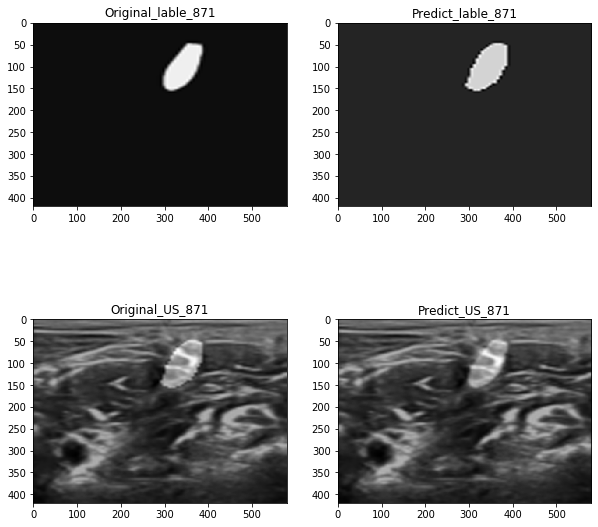

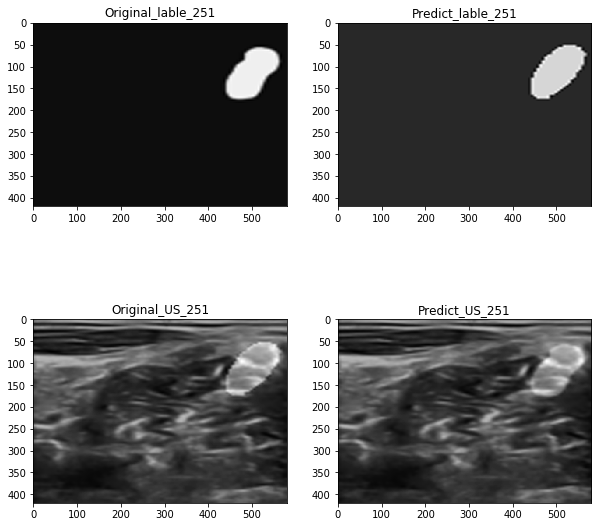

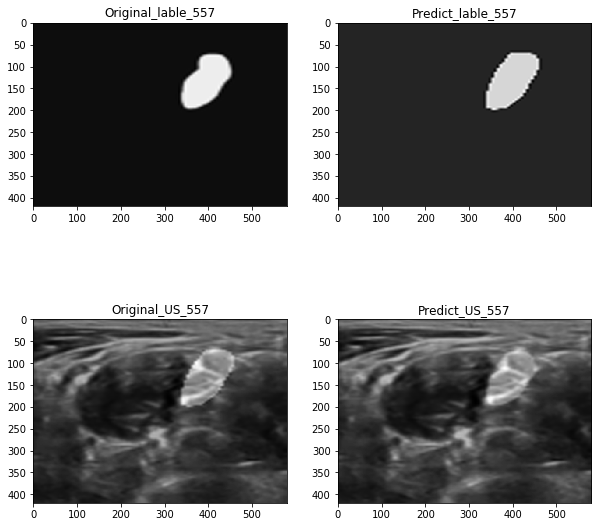

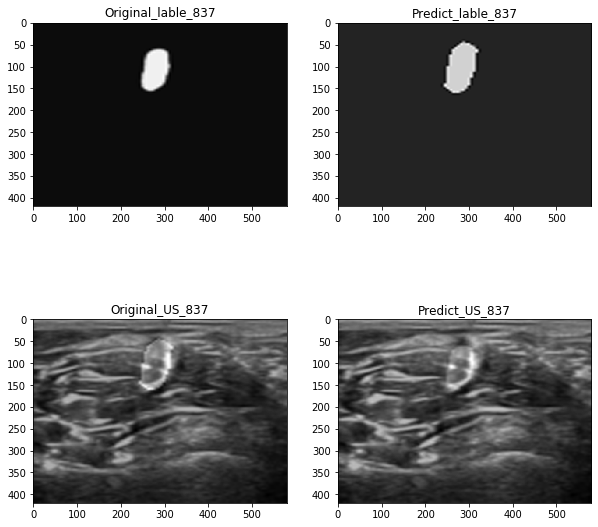

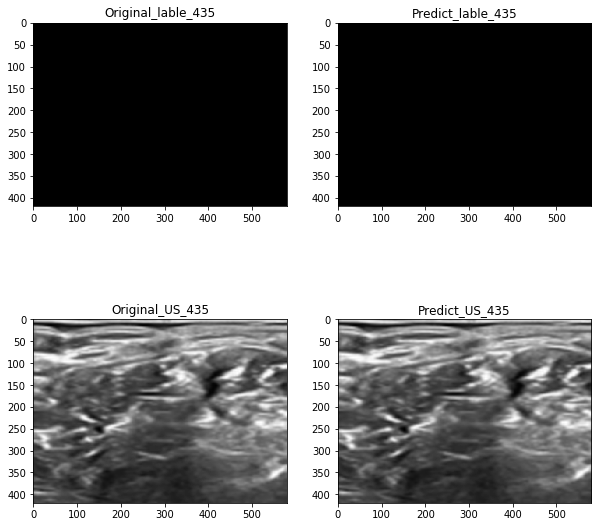

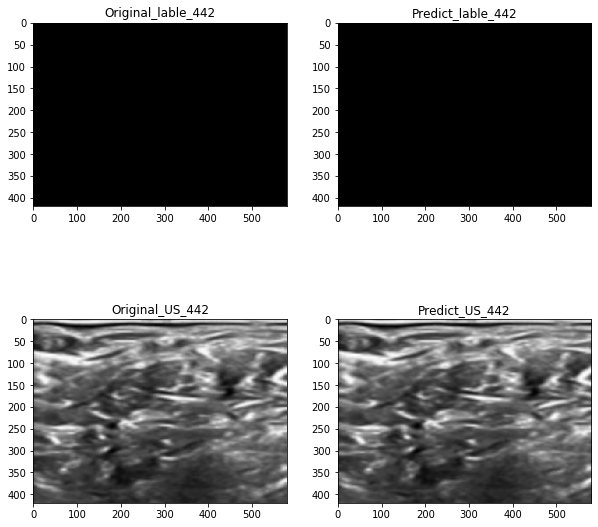

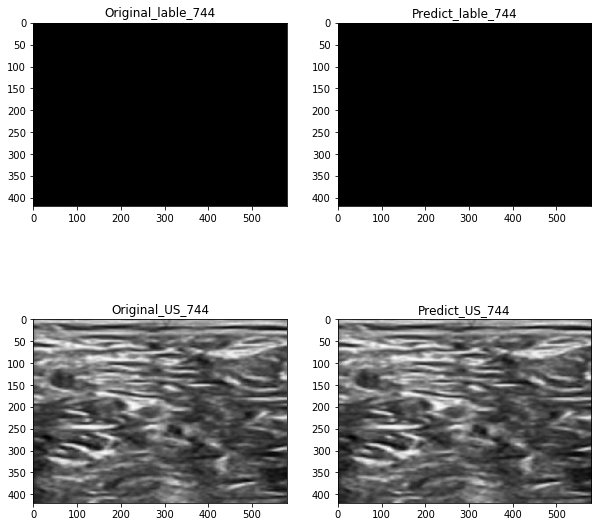

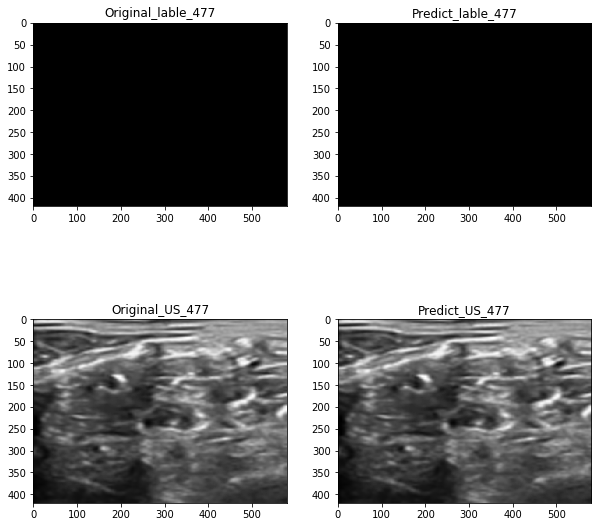

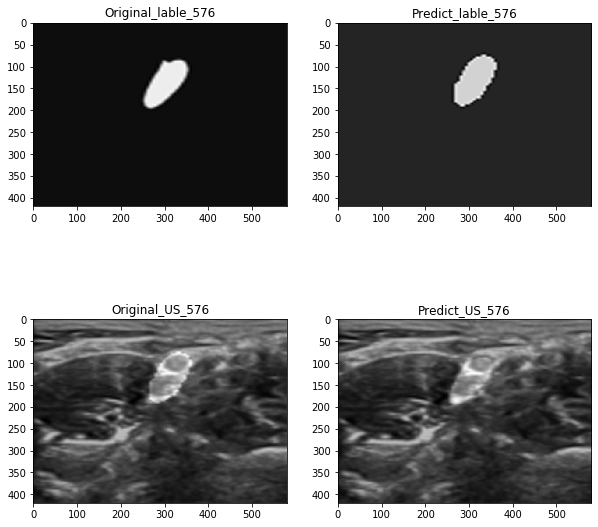

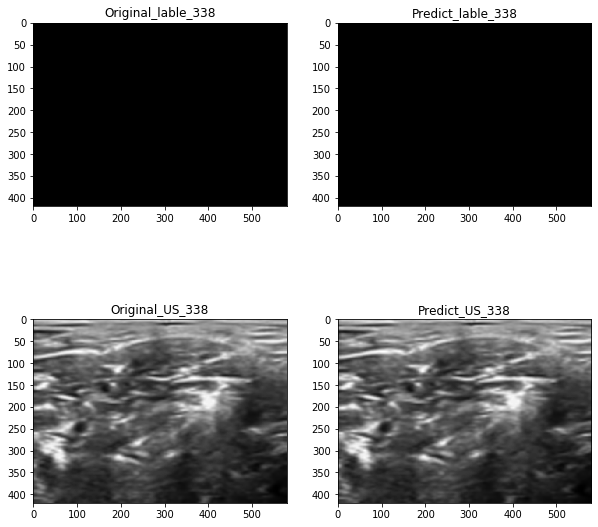



Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 14s - loss: 1.3872 - dice_coef: 0.2744 - recall: 0.5282 - precision: 0.2558 - mean_iou: 0.8492 - val_loss: 1.2953 - val_dice_coef: 0.2860 - val_recall: 0.7920 - val_precision: 0.1808 - val_mean_iou: 0.9496
Epoch 2/50
 - 7s - loss: 1.0725 - dice_coef: 0.4751 - recall: 0.5325 - precision: 0.4633 - mean_iou: 0.9831 - val_loss: 1.0549 - val_dice_coef: 0.4628 - val_recall: 0.5988 - val_precision: 0.3965 - val_mean_iou: 0.9813
Epoch 3/50
 - 6s - loss: 0.9541 - dice_coef: 0.5360 - recall: 0.5779 - precision: 0.5310 - mean_iou: 0.9850 - val_loss: 0.9752 - val_dice_coef: 0.4918 - val_recall: 0.4981 - val_precision: 0.5223 - val_mean_iou: 0.9863
Epoch 4/50
 - 6s - loss: 0.8719 - dice_coef: 0.5709 - recall: 0.6044 - precision: 0.5706 - mean_iou: 0.9859 - val_loss: 1.0335 - val_dice_coef: 0.3894 - val_recall: 0.7655 - val_precision: 0.2675 - val_mean_iou: 0.9684
Epoch 5/50
 - 6s - loss: 0.8175 - dice_coef: 0.5880 - recall: 0.6

Epoch 10/50
 - 7s - loss: 0.3239 - dice_coef: 0.7821 - recall: 0.7802 - precision: 0.8031 - mean_iou: 0.9903 - val_loss: 0.3088 - val_dice_coef: 0.7987 - val_recall: 0.8267 - val_precision: 0.7992 - val_mean_iou: 0.9909
Epoch 11/50
 - 7s - loss: 0.3219 - dice_coef: 0.7836 - recall: 0.7848 - precision: 0.8012 - mean_iou: 0.9903 - val_loss: 0.3092 - val_dice_coef: 0.7978 - val_recall: 0.8177 - val_precision: 0.8062 - val_mean_iou: 0.9910
Epoch 12/50
 - 7s - loss: 0.3179 - dice_coef: 0.7872 - recall: 0.7871 - precision: 0.8063 - mean_iou: 0.9903 - val_loss: 0.3123 - val_dice_coef: 0.7944 - val_recall: 0.8462 - val_precision: 0.7726 - val_mean_iou: 0.9906
Epoch 13/50
 - 7s - loss: 0.3159 - dice_coef: 0.7888 - recall: 0.7918 - precision: 0.8039 - mean_iou: 0.9904 - val_loss: 0.3103 - val_dice_coef: 0.7959 - val_recall: 0.8351 - val_precision: 0.7864 - val_mean_iou: 0.9908
Epoch 14/50
 - 7s - loss: 0.3131 - dice_coef: 0.7911 - recall: 0.7928 - precision: 0.8075 - mean_iou: 0.9904 - val_loss:

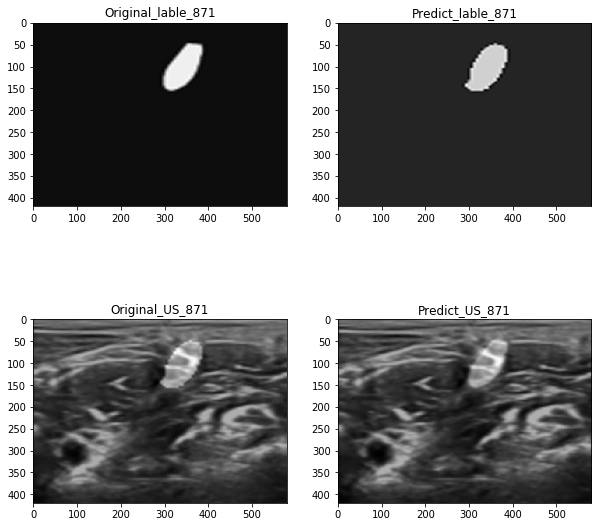

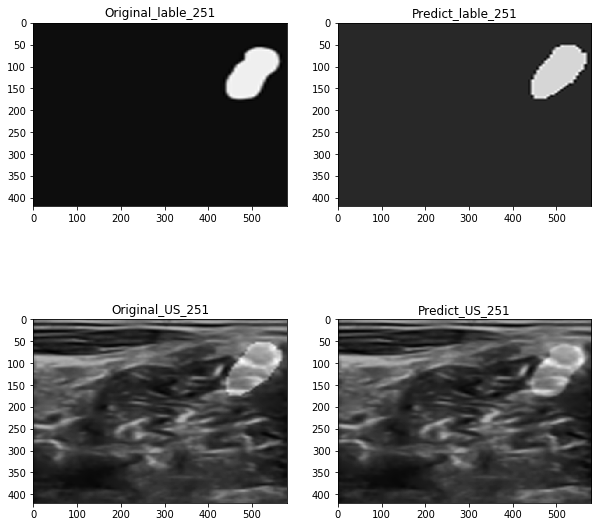

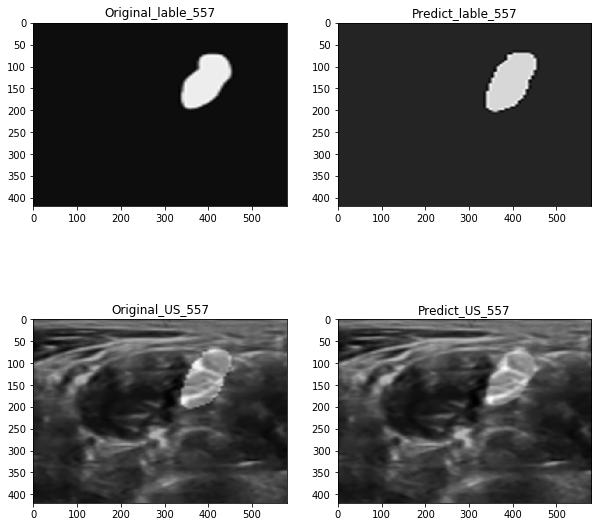

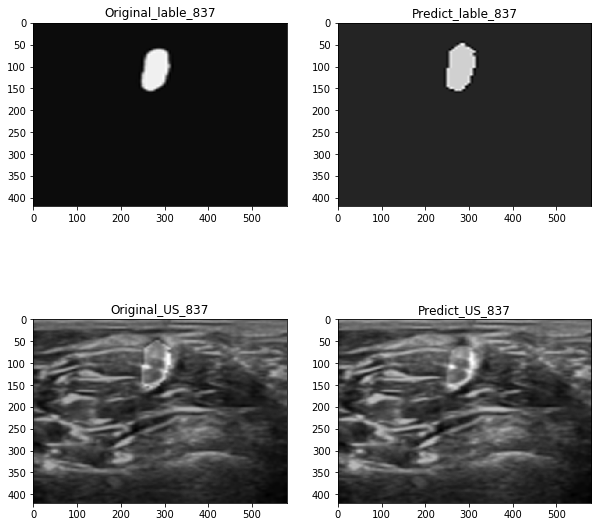

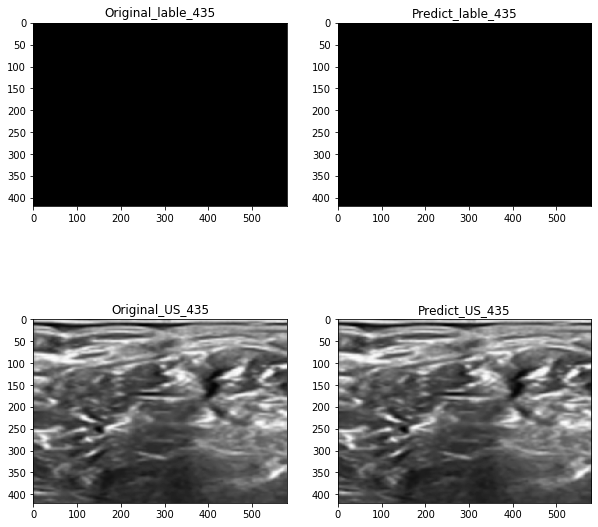

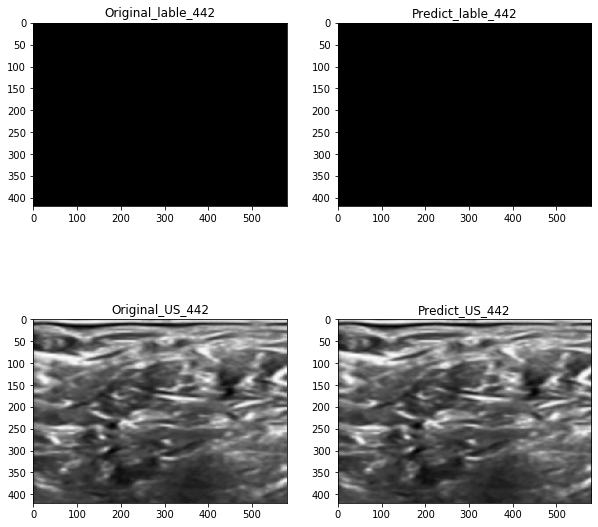

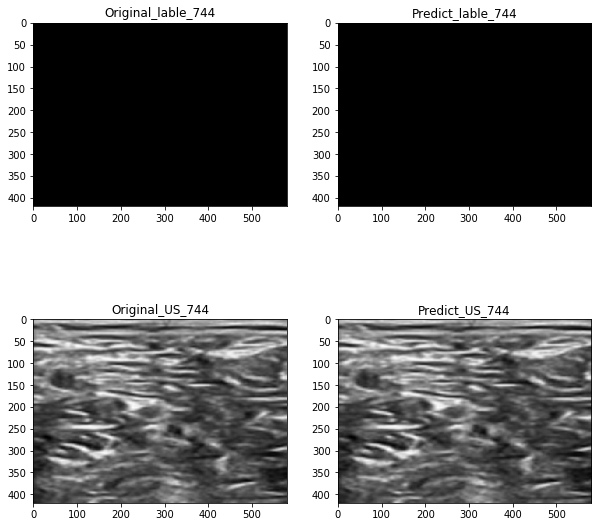

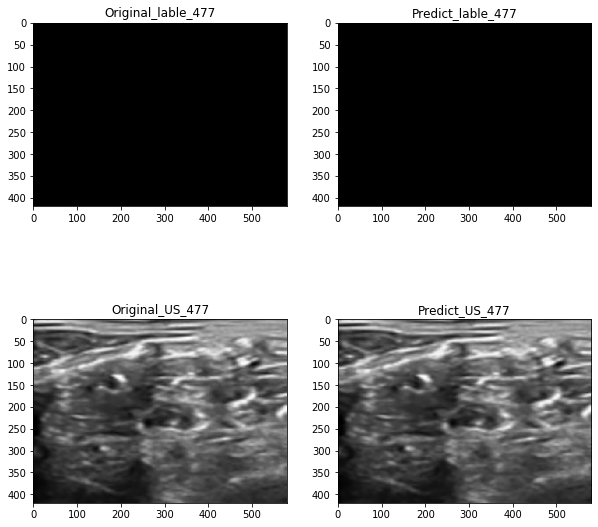

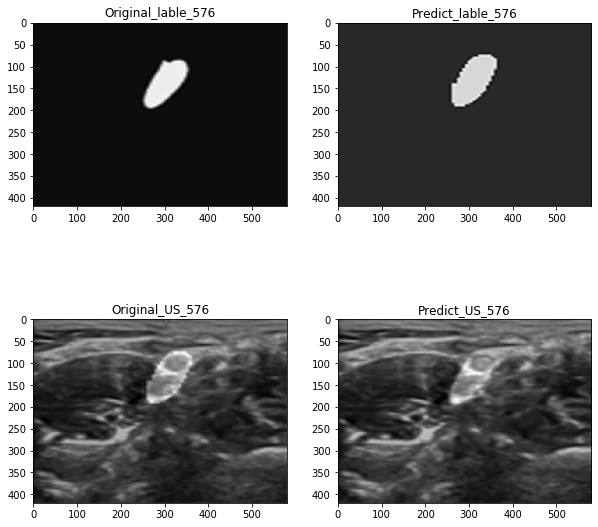

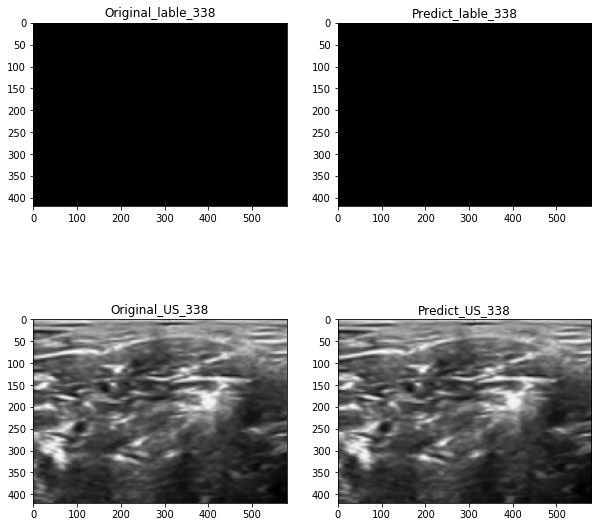



Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 14s - loss: 1.3943 - dice_coef: 0.2675 - recall: 0.5288 - precision: 0.2477 - mean_iou: 0.8488 - val_loss: 1.2777 - val_dice_coef: 0.3034 - val_recall: 0.7489 - val_precision: 0.1977 - val_mean_iou: 0.9561
Epoch 2/50
 - 7s - loss: 1.0653 - dice_coef: 0.4828 - recall: 0.5338 - precision: 0.4718 - mean_iou: 0.9835 - val_loss: 1.0569 - val_dice_coef: 0.4628 - val_recall: 0.4922 - val_precision: 0.4685 - val_mean_iou: 0.9850
Epoch 3/50
 - 7s - loss: 0.9556 - dice_coef: 0.5370 - recall: 0.5797 - precision: 0.5295 - mean_iou: 0.9850 - val_loss: 0.9822 - val_dice_coef: 0.4868 - val_recall: 0.6291 - val_precision: 0.4093 - val_mean_iou: 0.9817
Epoch 4/50
 - 7s - loss: 0.8771 - dice_coef: 0.5696 - recall: 0.6056 - precision: 0.5659 - mean_iou: 0.9858 - val_loss: 0.9475 - val_dice_coef: 0.4797 - val_recall: 0.6866 - val_precision: 0.3797 - val_mean_iou: 0.9795
Epoch 5/50
 - 7s - loss: 0.8187 - dice_coef: 0.5902 - recall: 0.6

Epoch 7/50
 - 7s - loss: 0.3383 - dice_coef: 0.7764 - recall: 0.7732 - precision: 0.7996 - mean_iou: 0.9902 - val_loss: 0.2955 - val_dice_coef: 0.8207 - val_recall: 0.8415 - val_precision: 0.8359 - val_mean_iou: 0.9915
Epoch 8/50
 - 7s - loss: 0.3406 - dice_coef: 0.7741 - recall: 0.7714 - precision: 0.7959 - mean_iou: 0.9902 - val_loss: 0.2971 - val_dice_coef: 0.8190 - val_recall: 0.8485 - val_precision: 0.8251 - val_mean_iou: 0.9914
Epoch 9/50
 - 7s - loss: 0.3387 - dice_coef: 0.7760 - recall: 0.7748 - precision: 0.7972 - mean_iou: 0.9902 - val_loss: 0.2960 - val_dice_coef: 0.8201 - val_recall: 0.8393 - val_precision: 0.8368 - val_mean_iou: 0.9915
Epoch 10/50
 - 7s - loss: 0.3384 - dice_coef: 0.7762 - recall: 0.7747 - precision: 0.7971 - mean_iou: 0.9902 - val_loss: 0.2973 - val_dice_coef: 0.8188 - val_recall: 0.8475 - val_precision: 0.8256 - val_mean_iou: 0.9914
Epoch 11/50
 - 7s - loss: 0.3375 - dice_coef: 0.7769 - recall: 0.7764 - precision: 0.7971 - mean_iou: 0.9902 - val_loss: 0.

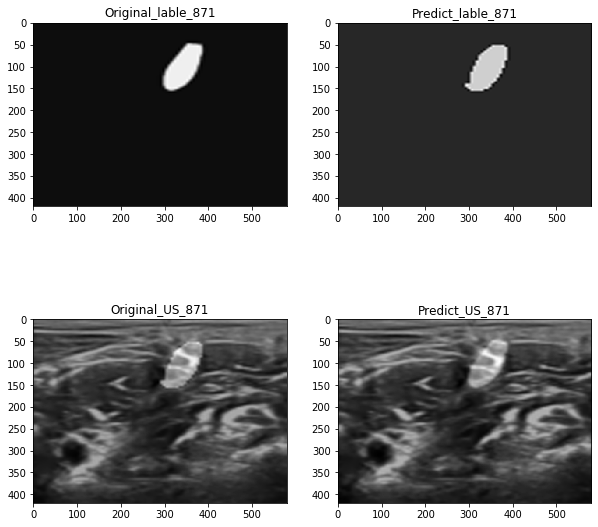

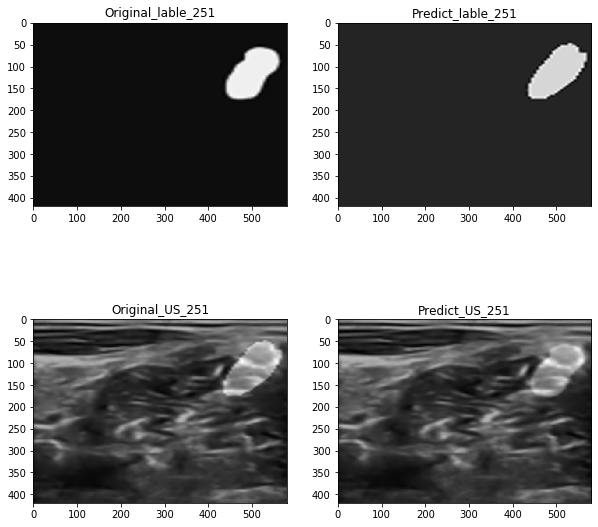

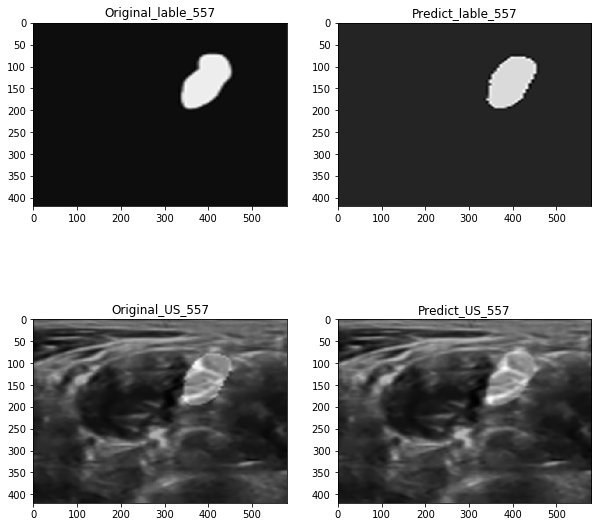

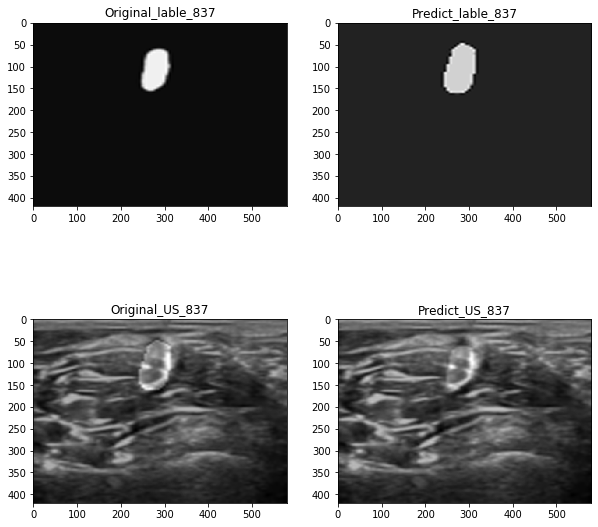

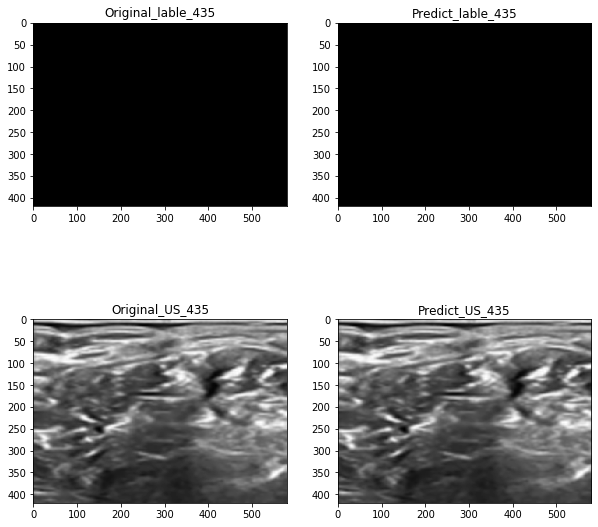

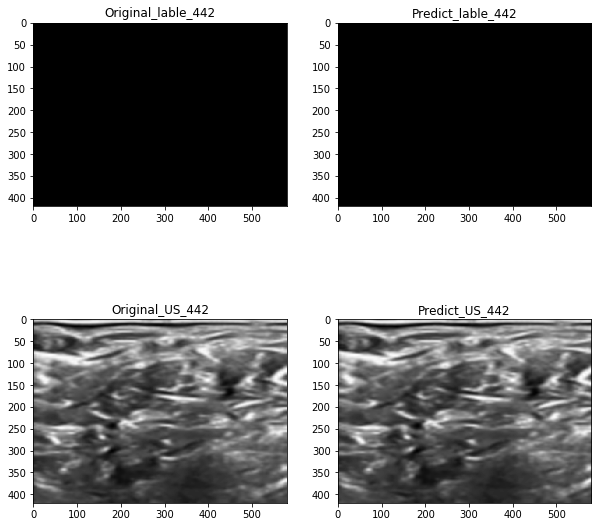

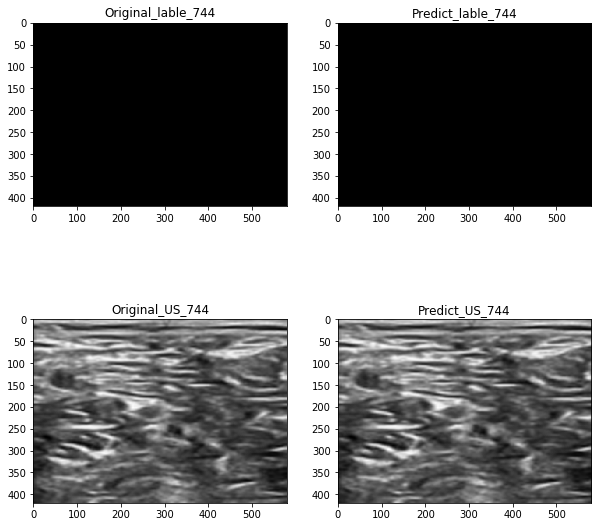

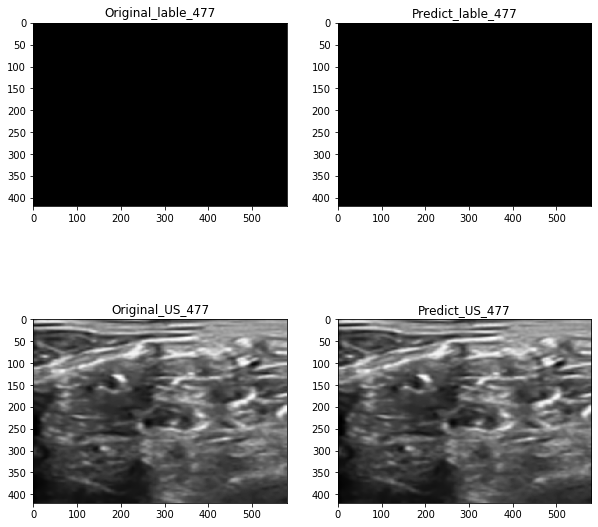

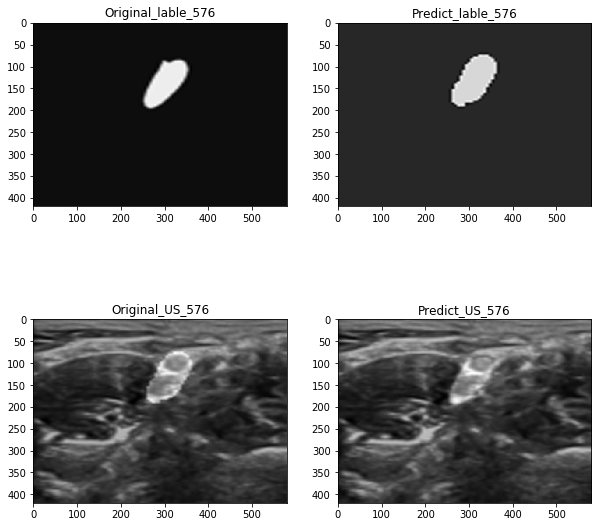

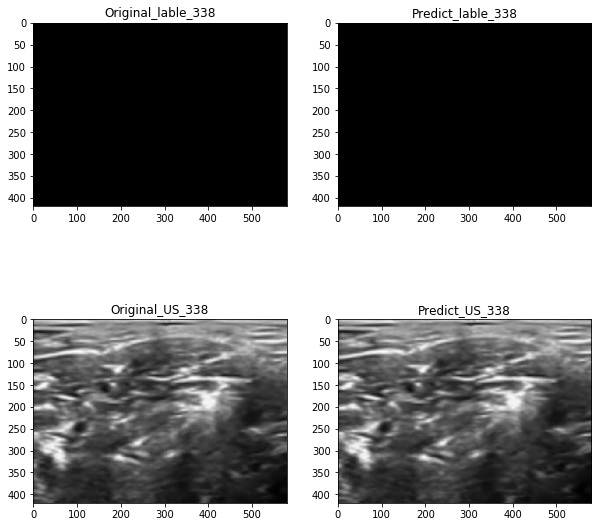

In [27]:
for ind_fil in [10,20,30]:
    image_t =h5py.File('./imgs_train_lemva_7_'+str(ind_fil) +'.h5', 'r')
    image_t =image_t.get('image')
    image_t= np.array(image_t)
    image_t=np.transpose(image_t)
    image_c = preprocess_img_n(image_t, ind_fil)
    for ind in ['']:
        path = "./Result/CAE/Lemva/7-"+str(ind_fil) +ind
        winodw_size = 0
        CAE = auto_encoder()

        for j, (train_idx, val_idx) in enumerate(folds):
            now = time.localtime()
            s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                          now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
            print('\nFold ', j)
            image_train_cv = image_c[train_idx]
            mask_train_cv = mask_c[train_idx]
            image_valid_cv = image_c[val_idx]
            mask_valid_cv = mask_c[val_idx]

            name_weights = path+"/final_model_fold_" + \
                str(j) + str(winodw_size) + "_weights.h5"
            callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

            history = CAE.fit(image_train_cv, mask_train_cv, epochs=50, verbose=2, shuffle=True, validation_data=(
            image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

            if history.history['dice_coef'][-1] < 0.05:
                break
            df = pd.DataFrame({"val_loss": history.history['val_loss'],
                           "val_dice_coef": history.history['val_dice_coef'],
                           "val_precision": history.history['val_precision'],
                           "val_recall": history.history['val_recall']})
            df = df*100
            df.to_csv(
                path+'/history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
            print(CAE.evaluate(image_valid_cv, mask_valid_cv, verbose=2))

        mask_predict = CAE.predict(image_valid_cv, verbose=2)

        mask_r = mask_predict.reshape(1127, 96, 96)
        mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
        image_test_u = image_valid_cv.reshape(1127, 96, 96)

        img_test_o = (mask_r*2)+image_test_u
        img_predict_o = image_test_u+(mask_test_u*2)

        np.random.seed(0)
        for num in np.random.choice(1127, 10, replace=False):
            plt.figure(figsize=(10, 10))
            plt.subplot(2, 2, 1)
            plt.imshow(cv2.resize(mask_test_u[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_lable_'+str(num))

            plt.subplot(2, 2, 2)
            plt.imshow(cv2.resize(mask_r[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_lable_'+str(num))

            plt.subplot(2, 2, 3)
            plt.imshow(cv2.resize(img_test_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_US_'+str(num))

            plt.subplot(2, 2, 4)
            plt.imshow(cv2.resize(img_predict_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_US_'+str(num))
            plt.savefig(path+'/Result'+str(num)+'.png')
            plt.show()

In [ ]:
["/새 폴더", "/새 폴더 (2)", "/새 폴더 (3)", "/새 폴더 (4)"]